# Importeer Libraries

In [865]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [866]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import sklearn
import os

# Download en importeer data bestanden

We beginnen met eerst de nodige data in te laden.

In [867]:
os.listdir("../data")

['.DS_Store',
 'station_data.csv',
 'weather_data.csv',
 'trip_data.csv',
 'previousValues.csv']

# Analyseer de Tabellen

We hebben 3 bestanden aan data beschikbaar, we laden ze in en bekijken eerst naar de data en trends die ze bevatten.

## Station data

In [868]:
station_data = pd.read_csv("../data/station_data.csv")
station_data.head()

,Id,Name,Lat,Long,Dock Count,City
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose


Elk station bevat verschillende gegevens:
- id: een unieke getal voor elk station
- Name: Naam van het station
- Lat: breedtegraad
- Long: lengtegraad
- Dock count: aantal plaatsen voor fietsen in het station
- City: De stad waar het station zich bevind

In [869]:
column_types = station_data.dtypes
print(column_types)

Id              int64
Name           object
Lat           float64
Long          float64
Dock Count      int64
City           object
dtype: object


Het type 'object' betekent string in dit geval. Alle kolommen staan reeds in de juiste vorm.

In [870]:
station_data['City'].value_counts()

City
San Francisco    39
San Jose         16
Redwood City      9
Mountain View     7
Palo Alto         5
Name: count, dtype: int64

In [871]:
station_data.groupby(['City'])['Dock Count'].sum()

City
Mountain View    117
Palo Alto         75
Redwood City     145
San Francisco    753
San Jose         264
Name: Dock Count, dtype: int64

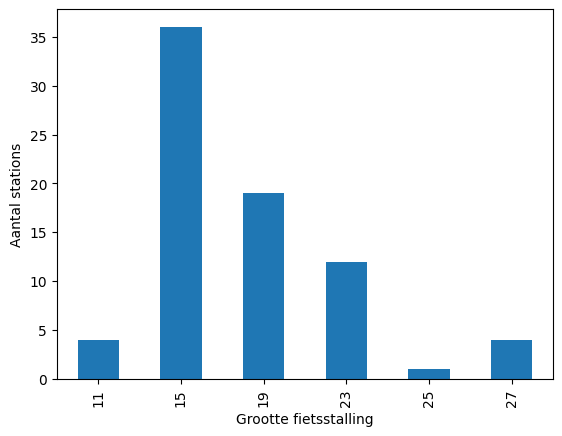

In [872]:
station_data['Dock Count'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Grootte fietsstalling')        
plt.ylabel('Aantal stations')
plt.show()

We zien hier dat elk station tussen de 11 en 27 plaatsen voor fietsen bevatten, en het grootste aantal stations plaats voor 15 fietsen heeft.

## Trip data

In [873]:
trip_data = pd.read_csv("../data/trip_data.csv")
trip_data.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type
0,891070,14/08/2015 23:49,82,14/08/2015 23:55,42,Subscriber
1,891069,14/08/2015 23:49,82,14/08/2015 23:58,87,Subscriber
2,891068,14/08/2015 23:49,60,14/08/2015 23:54,74,Subscriber
3,891067,14/08/2015 23:48,59,14/08/2015 23:51,59,Subscriber
4,891066,14/08/2015 23:38,28,14/08/2015 23:53,27,Subscriber


Elke trip die een persoon maakt bevat de volgende gegevens:
- Trip ID: een uniek number voor elke trip
- Start Date: start tijd en datum van de trip
- Start Station: Waar is de trip begonnen
- End Date: eind tijd en datum van de trip
- End Station: Waar is de trip beëindigd
- Subscriber Type: Wat soort abbonement heeft de gebruiker

In [874]:
column_types = trip_data.dtypes
print(column_types)

Trip ID             int64
Start Date         object
Start Station       int64
End Date           object
End Station         int64
Subscriber Type    object
dtype: object


Hier zien we dat de start en eind tijd in string formaat staan. Hierdoor kunnen we niet redeneren over tijd, wat een belangrijk aspect is voor het voorspellen van het aantal fietsen. We moeten deze dus eerst transformeren.

In [875]:
trip_data['Start Date'] = pd.to_datetime(trip_data['Start Date'], format='%d/%m/%Y %H:%M')
trip_data['End Date'] = pd.to_datetime(trip_data['End Date'], format='%d/%m/%Y %H:%M')
print(trip_data.dtypes)

Trip ID                     int64
Start Date         datetime64[ns]
Start Station               int64
End Date           datetime64[ns]
End Station                 int64
Subscriber Type            object
dtype: object


In [876]:
minDate = trip_data['Start Date'].min()
minDate

Timestamp('2014-09-01 00:05:00')

In [877]:
maxDate = trip_data['End Date'].max()
maxDate

Timestamp('2015-08-14 23:58:00')

We zien nu dat we ongeveer 1 jaar aan data hebben van September 2014 tot en met Augustus 2015.

In [878]:
trip_data["tripDuration"] = (trip_data['End Date']-trip_data['Start Date']).dt.total_seconds()/60
trip_data

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type,tripDuration
0,891070,2015-08-14 23:49:00,82,2015-08-14 23:55:00,42,Subscriber,6.0
1,891069,2015-08-14 23:49:00,82,2015-08-14 23:58:00,87,Subscriber,9.0
2,891068,2015-08-14 23:49:00,60,2015-08-14 23:54:00,74,Subscriber,5.0
3,891067,2015-08-14 23:48:00,59,2015-08-14 23:51:00,59,Subscriber,3.0
4,891066,2015-08-14 23:38:00,28,2015-08-14 23:53:00,27,Subscriber,15.0
...,...,...,...,...,...,...,...
336925,432951,2014-09-01 04:21:00,39,2014-09-01 04:32:00,65,Subscriber,11.0
336926,432950,2014-09-01 03:16:00,50,2014-09-01 05:08:00,70,Customer,112.0
336927,432949,2014-09-01 00:05:00,66,2014-09-01 00:14:00,57,Customer,9.0
336928,432948,2014-09-01 00:05:00,66,2014-09-01 00:15:00,57,Customer,10.0


count    336930.000000
mean         17.531333
std         512.855384
min           1.000000
25%           6.000000
50%           9.000000
75%          12.000000
max      287899.000000
Name: tripDuration, dtype: float64


Text(0, 0.5, '')

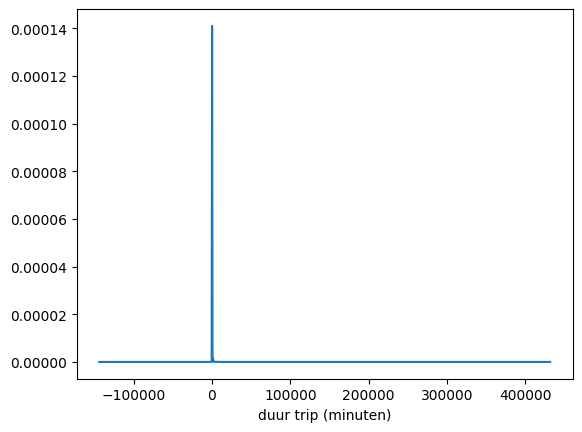

In [879]:
print(trip_data["tripDuration"].describe())
trip_data["tripDuration"].plot(kind='kde')
plt.xlabel('duur trip (minuten)')
plt.ylabel('')

De grafiek is niet zo overzichtelijk. Dit komt omdat er enkele trips tussen de gegevens zitten extreem lang geduurd zouden hebben.

/var/folders/sz/8rxgx3qj6dbgzd37w42pkg100000gn/T/ipykernel_23756/3631926327.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plt.bar(bin_labels, trip_data.groupby('duration_bins').size())


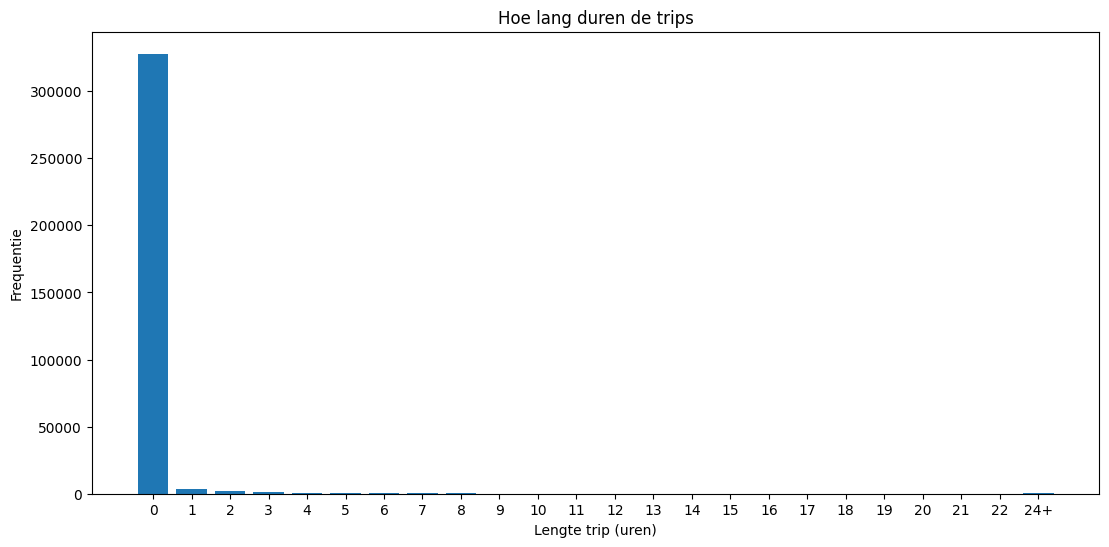

In [880]:
bin_edges = [i for i in range(0, 24, 1)] + [float('inf')]
bin_labels = [f'{i}' for i in range(0, 23, 1)] +['24+']

trip_data['duration_bins'] = pd.cut(trip_data['tripDuration']/60, bins=bin_edges, labels=bin_labels, right=False)
plt.figure(figsize=(13, 6))
plt.bar(bin_labels, trip_data.groupby('duration_bins').size())
plt.xlabel('Lengte trip (uren)')
plt.ylabel('Frequentie')
plt.title('Hoe lang duren de trips')

plt.show()


Als we dan iets verder inzoomen op de data zien we dat de overgrote hoeveelheid trips minder dan een uur zouden duren.

In [881]:
allRoutes = trip_data.groupby(['Start Station','End Station']).size().reset_index(name='trip_count')
popularRoutes = allRoutes.sort_values(by='trip_count', ascending=False).head(10)
popularRoutes

,Start Station,End Station,trip_count
741,50,60,2988
1085,61,50,2836
742,50,61,2524
790,51,70,2313
1596,74,61,2225
1068,60,74,2175
1259,65,70,2167
868,55,70,2070
1435,70,50,1992
1410,69,65,1988


In [882]:
print(station_data[station_data['Id'] == 50][['Id','Name','City','Dock Count']])
print(station_data[station_data['Id'] == 60][['Id','Name','City','Dock Count']])
print(station_data[station_data['Id'] == 61][['Id','Name','City','Dock Count']])
print(station_data[station_data['Id'] == 70][['Id','Name','City','Dock Count']])

    Id                                  Name           City  Dock Count
42  50  Harry Bridges Plaza (Ferry Building)  San Francisco          23
    Id                    Name           City  Dock Count
51  60  Embarcadero at Sansome  San Francisco          15
    Id             Name           City  Dock Count
52  61  2nd at Townsend  San Francisco          27
    Id                                      Name           City  Dock Count
62  70  San Francisco Caltrain (Townsend at 4th)  San Francisco          19


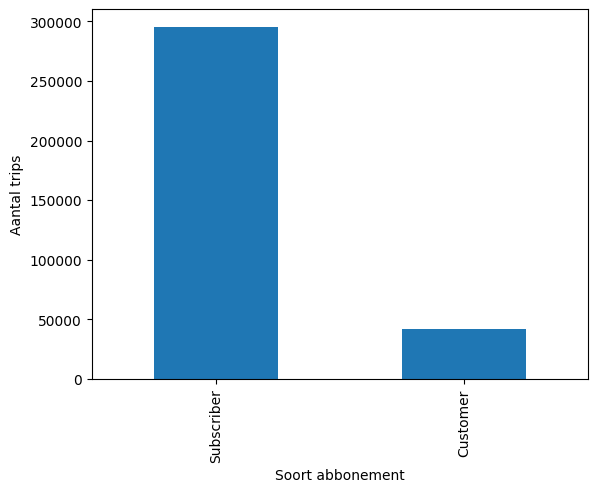

In [883]:
trip_data['Subscriber Type'].value_counts().plot(kind='bar')
plt.xlabel('Soort abbonement')        
plt.ylabel('Aantal trips')
plt.show()

Nu zou het interessant zijn om naar trends in de tijd te kunnen kijken. Zijn er spitsuren? Is het drukker tijdens het weekend of in de week? Is er een winterstop? Al deze vragen zijn relevant voor het voorspellen waar veel fietsen nodig zijn. <br>
Momenteel staan de tijdstippen opgeslagen in 1 kolom, onbewust kunnen wij dit in onze gedachten al opsplitsen in jaren, maanden, dagen, uren,...<br>
Maar het machine learning model kan dit niet, ook maakt dit het plotten meer ingewikkeld. Daarom splitsen we nu eerst de tijdstippen op.

In [884]:
# Splits Start Date op
trip_data['StartYear'] = trip_data['Start Date'].dt.year
trip_data['StartMonth'] = trip_data['Start Date'].dt.month
trip_data['StartDay'] = trip_data['Start Date'].dt.day
trip_data['StartWeekday'] = trip_data['Start Date'].dt.weekday  # Maandag is 0 en zondag is 6
trip_data['StartHour'] = trip_data['Start Date'].dt.hour
trip_data['StartMinute'] = trip_data['Start Date'].dt.minute

# Splits End Date op
trip_data['EndYear'] = trip_data['End Date'].dt.year
trip_data['EndMonth'] = trip_data['End Date'].dt.month
trip_data['EndDay'] = trip_data['End Date'].dt.day
trip_data['EndWeekday'] = trip_data['End Date'].dt.weekday  # Maandag is 0 en zondag is 6
trip_data['EndHour'] = trip_data['End Date'].dt.hour
trip_data['EndMinute'] = trip_data['End Date'].dt.minute

In [885]:
trip_data.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type,tripDuration,duration_bins,StartYear,StartMonth,StartDay,StartWeekday,StartHour,StartMinute,EndYear,EndMonth,EndDay,EndWeekday,EndHour,EndMinute
0,891070,2015-08-14 23:49:00,82,2015-08-14 23:55:00,42,Subscriber,6.0,0,2015,8,14,4,23,49,2015,8,14,4,23,55
1,891069,2015-08-14 23:49:00,82,2015-08-14 23:58:00,87,Subscriber,9.0,0,2015,8,14,4,23,49,2015,8,14,4,23,58
2,891068,2015-08-14 23:49:00,60,2015-08-14 23:54:00,74,Subscriber,5.0,0,2015,8,14,4,23,49,2015,8,14,4,23,54
3,891067,2015-08-14 23:48:00,59,2015-08-14 23:51:00,59,Subscriber,3.0,0,2015,8,14,4,23,48,2015,8,14,4,23,51
4,891066,2015-08-14 23:38:00,28,2015-08-14 23:53:00,27,Subscriber,15.0,0,2015,8,14,4,23,38,2015,8,14,4,23,53


Nu we zeker zijn dat de datum correct gesplitst is kunnen de we de originele tijdstippen verwijderen.

In [886]:
trip_data = trip_data.drop('Start Date',axis=1)
trip_data = trip_data.drop('End Date',axis=1)
trip_data.head()

,Trip ID,Start Station,End Station,Subscriber Type,tripDuration,duration_bins,StartYear,StartMonth,StartDay,StartWeekday,StartHour,StartMinute,EndYear,EndMonth,EndDay,EndWeekday,EndHour,EndMinute
0,891070,82,42,Subscriber,6.0,0,2015,8,14,4,23,49,2015,8,14,4,23,55
1,891069,82,87,Subscriber,9.0,0,2015,8,14,4,23,49,2015,8,14,4,23,58
2,891068,60,74,Subscriber,5.0,0,2015,8,14,4,23,49,2015,8,14,4,23,54
3,891067,59,59,Subscriber,3.0,0,2015,8,14,4,23,48,2015,8,14,4,23,51
4,891066,28,27,Subscriber,15.0,0,2015,8,14,4,23,38,2015,8,14,4,23,53


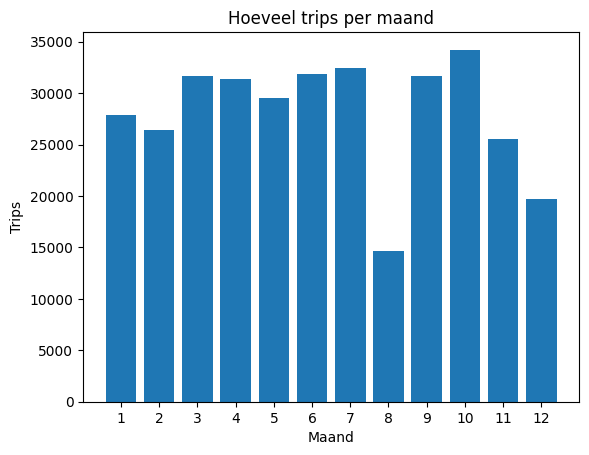

In [887]:
tripsPerMonth= trip_data['StartMonth'].value_counts().reset_index().sort_values(by= 'StartMonth')

plt.bar(tripsPerMonth['StartMonth'], tripsPerMonth['count'])
plt.xlabel('Maand')
plt.ylabel('Trips')
plt.xticks(tripsPerMonth['StartMonth'])
plt.title('Hoeveel trips per maand')
plt.show()


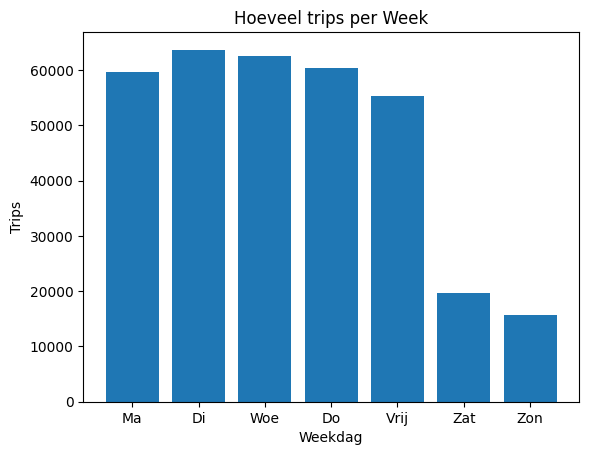

In [888]:
tripsPerWeek= trip_data['StartWeekday'].value_counts().reset_index().sort_values(by= 'StartWeekday')

plt.bar(tripsPerWeek['StartWeekday'], tripsPerWeek['count'])
plt.xlabel('Weekdag')
plt.ylabel('Trips')
plt.xticks(tripsPerWeek['StartWeekday'],['Ma', 'Di', 'Woe', 'Do', 'Vrij', 'Zat', 'Zon'])
plt.title('Hoeveel trips per Week')
plt.show()


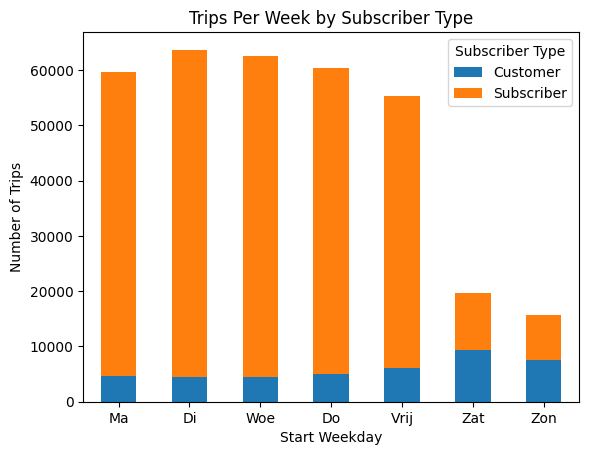

In [889]:
tripsPerWeek= trip_data.groupby(['StartWeekday','Subscriber Type']).size().unstack(fill_value=0)
fig, ax = plt.subplots()
tripsPerWeek.plot(kind='bar', stacked=True, ax=ax)

# Adding labels and title
ax.set_xlabel('Start Weekday')
ax.set_ylabel('Number of Trips')
ax.set_xticklabels(['Ma', 'Di', 'Woe', 'Do', 'Vrij', 'Zat', 'Zon'],rotation=0)
ax.set_title('Trips Per Week by Subscriber Type')

# Display the plot
plt.show()

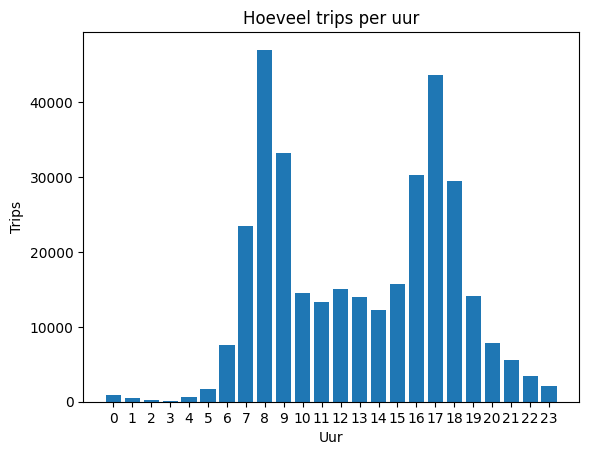

In [890]:
tripsPerHour= trip_data['StartHour'].value_counts().reset_index().sort_values(by= 'StartHour')

plt.bar(tripsPerHour['StartHour'], tripsPerHour['count'])
plt.xlabel('Uur')
plt.ylabel('Trips')
plt.xticks(tripsPerHour['StartHour'])
plt.title('Hoeveel trips per uur')
plt.show()


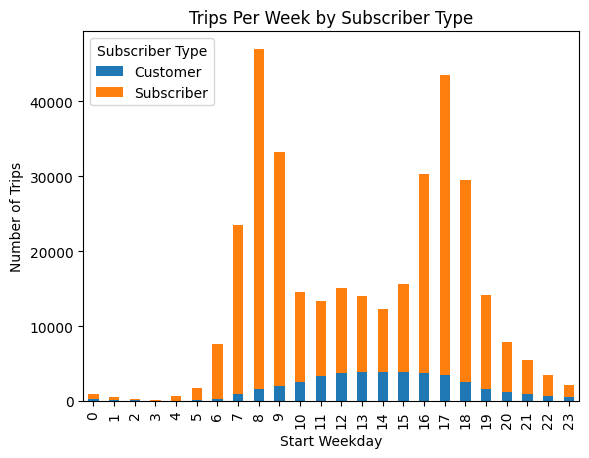

In [891]:
tripsPerWeek= trip_data.groupby(['StartHour','Subscriber Type']).size().unstack(fill_value=0)
fig, ax = plt.subplots()
tripsPerWeek.plot(kind='bar', stacked=True, ax=ax)

# Adding labels and title

ax.set_xlabel('Start Weekday')
ax.set_ylabel('Number of Trips')
ax.set_title('Trips Per Week by Subscriber Type')

# Display the plot
plt.show()

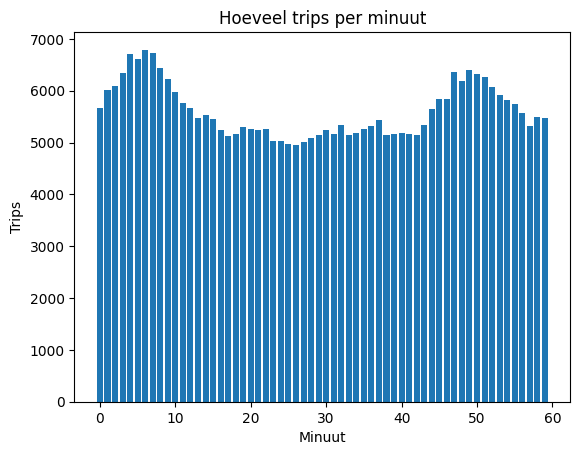

In [892]:
tripsPerHour= trip_data['StartMinute'].value_counts().reset_index().sort_values(by= 'StartMinute')

plt.bar(tripsPerHour['StartMinute'], tripsPerHour['count'])
plt.xlabel('Minuut')
plt.ylabel('Trips')
plt.title('Hoeveel trips per minuut')
plt.show()


In [893]:
weather_data = pd.read_csv("../data/weather_data.csv")
weather_data.head()

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip
0,01/09/2014,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,10.0,8.0,16.0,7.0,20.0,0.0,0.0,NaN,290.0,94107
1,02/09/2014,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,...,10.0,7.0,21.0,8.0,NaN,0.0,5.0,NaN,290.0,94107
2,03/09/2014,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,...,10.0,10.0,21.0,8.0,24.0,0.0,4.0,NaN,276.0,94107
3,04/09/2014,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,...,10.0,8.0,22.0,8.0,25.0,0.0,5.0,NaN,301.0,94107
4,05/09/2014,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,...,9.0,7.0,18.0,8.0,32.0,0.0,4.0,NaN,309.0,94107


In [894]:
column_types = weather_data.dtypes
print(column_types)

Date                          object
Max TemperatureF             float64
Mean TemperatureF            float64
Min TemperatureF             float64
Max Dew PointF               float64
MeanDew PointF               float64
Min DewpointF                float64
Max Humidity                 float64
Mean Humidity                float64
Min Humidity                 float64
Max Sea Level PressureIn     float64
Mean Sea Level PressureIn    float64
Min Sea Level PressureIn     float64
Max VisibilityMiles          float64
Mean VisibilityMiles         float64
Min VisibilityMiles          float64
Max Wind SpeedMPH            float64
Mean Wind SpeedMPH           float64
Max Gust SpeedMPH            float64
PrecipitationIn              float64
CloudCover                   float64
Events                        object
WindDirDegrees               float64
Zip                            int64
dtype: object


In [895]:
weather_data['Date'] = pd.to_datetime(weather_data['Date'], format='%d/%m/%Y')
weather_data['Mean TemperatureC'] = (weather_data['Mean TemperatureF'] - 32) * 5/9
weather_data['Mean TemperatureC'] = weather_data['Mean TemperatureC'].round(2)


In [896]:
weather_data['Zip'].value_counts()

Zip
94107    365
94063    365
94301    365
94041    365
95113    348
Name: count, dtype: int64

In [897]:
weather_data = weather_data[weather_data['Zip'] == 94107]

<Axes: xlabel='Events'>

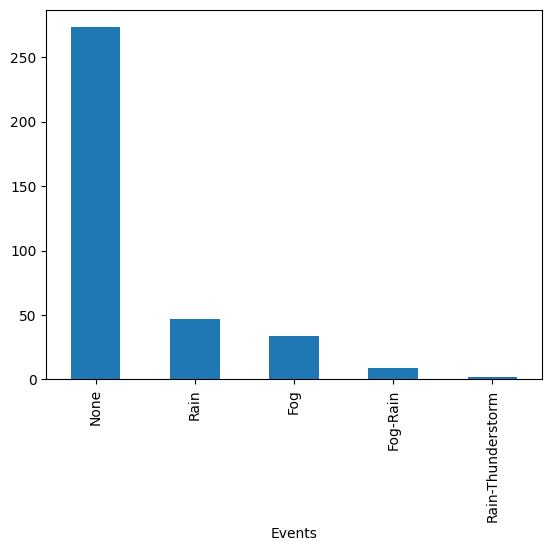

In [898]:
weather_data['Events'] = weather_data['Events'].fillna('None')
weather_data['Events'].value_counts().plot(kind='bar')

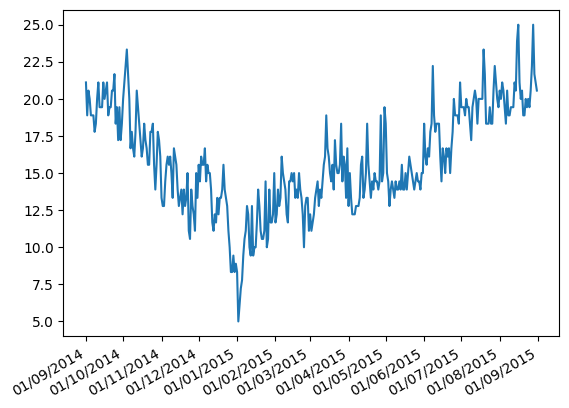

In [899]:
from matplotlib.dates import DateFormatter, MonthLocator

plt.plot(weather_data['Date'], weather_data['Mean TemperatureC'])
plt.gca().xaxis.set_major_locator(MonthLocator(bymonthday=1))  # Show a subset of ticks for better readability
plt.gca().xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))  # Format as 'YYYY-MM-DD'

# Rotate x-axis labels for better readability
plt.gcf().autofmt_xdate()
plt.show()


## Data transformatie

Nu dat we een beter begrip hebben van de gegevens, is het tijd om de data klaar te maken voor een machine learning model. <br>
De data moet 2 onderdelen bevatten voor we ons model kunnen trainen. <br> 
1. Eerst moeten we een 'Target' hebben, de waarde die we willen voorspellen. In deze opdracht willen we ervoor zorgen dat op elk moment fietsen beschikbaar zijn voor de klanten. We weten niets over het absolute aantal fietsen op een station, dus deze waarde is moeilijk te voorspellen. Wat we wel weten is hoeveel fietsen aankomen en vertrekken op een bepaald station. Hierdoor kunnen we een netto verandering aan fietsen berekenen en ook voorspellen. Deze verandering per uur bekijken lijkt een goeie target, per minuut is te ambitieus en geeft ook geen tijd voor de volgwagen om nieuwe fietsen te leveren waar nodig, en aangezien de meeste trips korter zijn dan één uur gaat per dag een te groot venster zijn. Plaatsen waar we grote veranderingen voorspellen kunnen we de volgauto naartoe sturen, om extra fietsen af/op te laden.<br>
2. Ten tweede hebben we features nodig die het model kan gebruiken om onze target te voorspellen. De exploratie die we juist gedaan hebben kan hiervoor nuttig zijn alsook onze eigen intuitie. We zagen bijvoorbeeld dat er 2 piek uren rond 8 en rond 17, het uur is dus een belangrijke feature om de verandering aan fietsen te voorspellen. Andere gegevens zoals de dag van de week, de maand, welk station, het weer zijn allemaal zaken die invloed kunnen hebben op verandering aan fietsen.

In [900]:
trip_data.head()

,Trip ID,Start Station,End Station,Subscriber Type,tripDuration,duration_bins,StartYear,StartMonth,StartDay,StartWeekday,StartHour,StartMinute,EndYear,EndMonth,EndDay,EndWeekday,EndHour,EndMinute
0,891070,82,42,Subscriber,6.0,0,2015,8,14,4,23,49,2015,8,14,4,23,55
1,891069,82,87,Subscriber,9.0,0,2015,8,14,4,23,49,2015,8,14,4,23,58
2,891068,60,74,Subscriber,5.0,0,2015,8,14,4,23,49,2015,8,14,4,23,54
3,891067,59,59,Subscriber,3.0,0,2015,8,14,4,23,48,2015,8,14,4,23,51
4,891066,28,27,Subscriber,15.0,0,2015,8,14,4,23,38,2015,8,14,4,23,53


Dit is de data waar we mee zijn geeindigt na de voorgaande analyse. We kunnen deze eerst wat opschonen en de tripDuration, duration_bins en Start/End minuten verwijderen (We voorspellen per uur dus de minuten zijn niet meer nodig).

In [901]:
trip_data = trip_data.drop('tripDuration',axis=1)
trip_data = trip_data.drop('duration_bins',axis=1)
trip_data = trip_data.drop('StartMinute',axis=1)
trip_data = trip_data.drop('EndMinute',axis=1)
trip_data.head()

,Trip ID,Start Station,End Station,Subscriber Type,StartYear,StartMonth,StartDay,StartWeekday,StartHour,EndYear,EndMonth,EndDay,EndWeekday,EndHour
0,891070,82,42,Subscriber,2015,8,14,4,23,2015,8,14,4,23
1,891069,82,87,Subscriber,2015,8,14,4,23,2015,8,14,4,23
2,891068,60,74,Subscriber,2015,8,14,4,23,2015,8,14,4,23
3,891067,59,59,Subscriber,2015,8,14,4,23,2015,8,14,4,23
4,891066,28,27,Subscriber,2015,8,14,4,23,2015,8,14,4,23


Om de netto verandering in fietsen op een bepaald station te voorspellen hebben we 2 onderdelen nodig, de fietsen die aankomen in dit station (End Station) en degene die vertrekken vanaf dit station (Start Station)

In [902]:
IncomingBikes = trip_data.groupby(['Start Station', 'StartYear','StartMonth','StartDay','StartHour']).size().reset_index(name='incoming')
IncomingBikes.head()


,Start Station,StartYear,StartMonth,StartDay,StartHour,incoming
0,2,2014,9,1,12,1
1,2,2014,9,1,21,4
2,2,2014,9,1,22,1
3,2,2014,9,2,1,1
4,2,2014,9,2,7,3


We weten niet of er op elk uur een fiets vertrekt of aankomt op een bepaald station. Dus we maken eerst een dataset aan die voor elk station alle uren bevat.

In [903]:
date_range = pd.date_range(start=minDate, end=maxDate, freq='H')
date_df = pd.DataFrame(date_range, columns=['datetime'])
date_df['dateIndex'] = range(len(date_df)) # We voegen een tijdsindex toe, deze gaat ons later helpen

stations_df = pd.DataFrame(trip_data['Start Station'].unique(), columns=['Station'])
stationTime_df = pd.merge(date_df,stations_df,how='cross')
stationTime_df['year'] = stationTime_df['datetime'].dt.year
stationTime_df['month'] = stationTime_df['datetime'].dt.month
stationTime_df['day'] = stationTime_df['datetime'].dt.day
stationTime_df['weekday'] = stationTime_df['datetime'].dt.weekday
stationTime_df['hour'] = stationTime_df['datetime'].dt.hour
stationTime_df= stationTime_df.drop('datetime',axis=1)
stationTime_df.head()

,dateIndex,Station,year,month,day,weekday,hour
0,0,82,2014,9,1,0,0
1,0,60,2014,9,1,0,0
2,0,59,2014,9,1,0,0
3,0,28,2014,9,1,0,0
4,0,50,2014,9,1,0,0


In [904]:
IncomingBikes = pd.merge(stationTime_df, IncomingBikes, left_on=['Station', 'year','month','day','hour'],right_on=['Start Station','StartYear','StartMonth','StartDay','StartHour'] , how='left')
IncomingBikes = IncomingBikes.drop(['Start Station','StartYear','StartMonth','StartDay','StartHour'],axis=1)
IncomingBikes['incoming'] = IncomingBikes['incoming'].fillna(0).astype(int)
IncomingBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,incoming
0,0,82,2014,9,1,0,0,0
1,0,60,2014,9,1,0,0,0
2,0,59,2014,9,1,0,0,0
3,0,28,2014,9,1,0,0,0
4,0,50,2014,9,1,0,0,0


In [905]:
OutGoingBikes = trip_data.groupby(['End Station', 'EndYear','EndMonth','EndDay','EndHour']).size().reset_index(name='outgoing')
OutGoingBikes.head()
OutGoingBikes = pd.merge(stationTime_df, OutGoingBikes, left_on=['Station', 'year','month','day','hour'],right_on=['End Station','EndYear','EndMonth','EndDay','EndHour'] , how='left')
OutGoingBikes = OutGoingBikes.drop(['End Station','EndYear','EndMonth','EndDay','EndHour'],axis=1)
OutGoingBikes['outgoing'] = OutGoingBikes['outgoing'].fillna(0).astype(int)
OutGoingBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,outgoing
0,0,82,2014,9,1,0,0,0
1,0,60,2014,9,1,0,0,0
2,0,59,2014,9,1,0,0,0
3,0,28,2014,9,1,0,0,0
4,0,50,2014,9,1,0,0,0


In [906]:
ChangeInBikes = pd.merge(IncomingBikes,OutGoingBikes,on=['dateIndex','Station','year','month','day','hour','weekday'],how= 'left')
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,incoming,outgoing
0,0,82,2014,9,1,0,0,0,0
1,0,60,2014,9,1,0,0,0,0
2,0,59,2014,9,1,0,0,0,0
3,0,28,2014,9,1,0,0,0,0
4,0,50,2014,9,1,0,0,0,0


In [907]:
ChangeInBikes['netBikeChange'] = ChangeInBikes['incoming'] - ChangeInBikes['outgoing']
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,incoming,outgoing,netBikeChange
0,0,82,2014,9,1,0,0,0,0,0
1,0,60,2014,9,1,0,0,0,0,0
2,0,59,2014,9,1,0,0,0,0,0
3,0,28,2014,9,1,0,0,0,0,0
4,0,50,2014,9,1,0,0,0,0,0


NetBikeChange is onze target value en dus de waarde die we willen voorspellen, de overige kolommen zijn al enkele features die we kunnen gebruiken om de voorspelling te maken. Natuurlijk de incoming en outgoing waardes zijn onbekend tijdens het voorspellen, dus die verwijderen we nog eerst.

In [908]:
ChangeInBikes= ChangeInBikes.drop(['incoming','outgoing'],axis=1)
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,netBikeChange
0,0,82,2014,9,1,0,0,0
1,0,60,2014,9,1,0,0,0
2,0,59,2014,9,1,0,0,0
3,0,28,2014,9,1,0,0,0
4,0,50,2014,9,1,0,0,0


Nu kunnen we even nadenken welke andere features nog van pas zouden komen.
- Het aantal fiestenstalling in een station
- de Stad waarin het station zich bevindt
- Is het weekend?
- Weer events (regen,mist,...)
- Temperatuur

In [909]:
ChangeInBikes['IsWeekend'] = ChangeInBikes['weekday'].isin([5, 6]).astype(int)
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,netBikeChange,IsWeekend
0,0,82,2014,9,1,0,0,0,0
1,0,60,2014,9,1,0,0,0,0
2,0,59,2014,9,1,0,0,0,0
3,0,28,2014,9,1,0,0,0,0
4,0,50,2014,9,1,0,0,0,0


In [910]:
ChangeInBikes = pd.merge(ChangeInBikes, station_data, left_on='Station', right_on='Id',how='left')
ChangeInBikes = ChangeInBikes.drop(['Id','Name','Lat','Long'],axis=1)
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,netBikeChange,IsWeekend,Dock Count,City
0,0,82,2014,9,1,0,0,0,0,15,San Francisco
1,0,60,2014,9,1,0,0,0,0,15,San Francisco
2,0,59,2014,9,1,0,0,0,0,23,San Francisco
3,0,28,2014,9,1,0,0,0,0,23,Mountain View
4,0,50,2014,9,1,0,0,0,0,23,San Francisco


We kunnen de stad niet zomaar gebruiken, niet alle modellen kunnen werken met categorie waarden. We zullen deze eerst veranderen via one-hot encoding.

In [911]:
ChangeInBikes['City'] = ChangeInBikes['City'].str.replace(' ','_')
citiesEncoded = pd.get_dummies(ChangeInBikes['City'], prefix='City')
ChangeInBikes = pd.concat([ChangeInBikes, citiesEncoded], axis=1)
ChangeInBikes= ChangeInBikes.drop('City',axis=1)
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,netBikeChange,IsWeekend,Dock Count,City_Mountain_View,City_Palo_Alto,City_Redwood_City,City_San_Francisco,City_San_Jose
0,0,82,2014,9,1,0,0,0,0,15,False,False,False,True,False
1,0,60,2014,9,1,0,0,0,0,15,False,False,False,True,False
2,0,59,2014,9,1,0,0,0,0,23,False,False,False,True,False
3,0,28,2014,9,1,0,0,0,0,23,True,False,False,False,False
4,0,50,2014,9,1,0,0,0,0,23,False,False,False,True,False


Voor we de 2 features over het weer kunnen toevoegen moeten we de datums van de weer tabel aanpassen. Beide datums moeten in dezelfde vorm staan zodat we de tabellen kunnen verbinden.

In [912]:
weather_data['year'] = weather_data['Date'].dt.year
weather_data['month'] = weather_data['Date'].dt.month
weather_data['day'] = weather_data['Date'].dt.day
weather_data.head()

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip,Mean TemperatureC,year,month,day
0,2014-09-01,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,20.0,0.0,0.0,None,290.0,94107,21.11,2014,9,1
1,2014-09-02,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,...,NaN,0.0,5.0,None,290.0,94107,18.89,2014,9,2
2,2014-09-03,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,...,24.0,0.0,4.0,None,276.0,94107,20.56,2014,9,3
3,2014-09-04,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,...,25.0,0.0,5.0,None,301.0,94107,20.00,2014,9,4
4,2014-09-05,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,...,32.0,0.0,4.0,None,309.0,94107,18.89,2014,9,5


In [913]:
weather_data_features = weather_data[['year','month','day','Mean TemperatureC','Events']]
weather_data_features.head()

,year,month,day,Mean TemperatureC,Events
0,2014,9,1,21.11,None
1,2014,9,2,18.89,None
2,2014,9,3,20.56,None
3,2014,9,4,20.00,None
4,2014,9,5,18.89,None


In [914]:
weather_data_features['Events'] = weather_data_features['Events'].str.replace(' ','_')
weatherEncoded = pd.get_dummies(weather_data_features['Events'], prefix='Event')
weather_data_features = pd.concat([weather_data_features, weatherEncoded], axis=1)
weather_data_features= weather_data_features.drop('Events',axis=1)
weather_data_features.head()

/var/folders/sz/8rxgx3qj6dbgzd37w42pkg100000gn/T/ipykernel_23756/961348740.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_features['Events'] = weather_data_features['Events'].str.replace(' ','_')


,year,month,day,Mean TemperatureC,Event_Fog,Event_Fog-Rain,Event_None,Event_Rain,Event_Rain-Thunderstorm
0,2014,9,1,21.11,False,False,True,False,False
1,2014,9,2,18.89,False,False,True,False,False
2,2014,9,3,20.56,False,False,True,False,False
3,2014,9,4,20.00,False,False,True,False,False
4,2014,9,5,18.89,False,False,True,False,False


In [915]:
ChangeInBikes = pd.merge(ChangeInBikes, weather_data_features, on=['year','month','day'],how='left')
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,netBikeChange,IsWeekend,Dock Count,...,City_Palo_Alto,City_Redwood_City,City_San_Francisco,City_San_Jose,Mean TemperatureC,Event_Fog,Event_Fog-Rain,Event_None,Event_Rain,Event_Rain-Thunderstorm
0,0,82,2014,9,1,0,0,0,0,15,...,False,False,True,False,21.11,False,False,True,False,False
1,0,60,2014,9,1,0,0,0,0,15,...,False,False,True,False,21.11,False,False,True,False,False
2,0,59,2014,9,1,0,0,0,0,23,...,False,False,True,False,21.11,False,False,True,False,False
3,0,28,2014,9,1,0,0,0,0,23,...,False,False,False,False,21.11,False,False,True,False,False
4,0,50,2014,9,1,0,0,0,0,23,...,False,False,True,False,21.11,False,False,True,False,False


Een volgend feature dat kan helpen, is een zeer populaire bij het voorspellen van waarden over tijd (Time series predictions). Namelijk de waarde van het vorige uur (of van de vorige uren). Als we terugdenken aan onze piek uren, herinneren we ons dat drukke periodes niet plots opdaagden, maar geleidelijk op en afbouwt. 

Hier komt de tijdsindex terug van pas

In [916]:
def getNetChangeFromPreviousHour(df,dateIndex,station,n=1):
    if (dateIndex-n) > 0:
        prevNetChange = df.loc[(df['dateIndex'] == dateIndex-n) & (df['Station'] == station), 'netBikeChange'].values[0]
    else:
        prevNetChange = 0
    return prevNetChange

Dit zijn zwaardere functies aangezien we over elke rij moeten gaan en vervolgens voor elke rij de vorige waardes opzoeken in de tabel. Daarom is er ook een bestandje toegevoegd dat de nodige waardes al bevat. Door deze te linken aan onze tabel kunnen we wat tijd besparen.

In [917]:
#ChangeInBikes['NetBikeChange-1'] = ChangeInBikes.apply(lambda row: getNetChangeFromPreviousHour(ChangeInBikes,row['dateIndex'], row['Station']), axis=1)
#ChangeInBikes['NetBikeChange-2'] = ChangeInBikes.apply(lambda row: getNetChangeFromPreviousHour(ChangeInBikes,row['dateIndex'], row['Station'],2), axis=1)

De volgende functie laad het bestand in en voegt de waardes toe aan de feature tabel.

In [923]:
previousValues = pd.read_csv("../data/previousValues.csv")
ChangeInBikes = pd.merge(ChangeInBikes, previousValues, on=['dateIndex','Station'],how='left')
ChangeInBikes.head()

,dateIndex,Station,year,month,day,weekday,hour,netBikeChange,IsWeekend,Dock Count,...,City_San_Francisco,City_San_Jose,Mean TemperatureC,Event_Fog,Event_Fog-Rain,Event_None,Event_Rain,Event_Rain-Thunderstorm,NetBikeChange-1,NetBikeChange-2
0,0,82,2014,9,1,0,0,0,0,15,...,True,False,21.11,False,False,True,False,False,0,0
1,0,60,2014,9,1,0,0,0,0,15,...,True,False,21.11,False,False,True,False,False,0,0
2,0,59,2014,9,1,0,0,0,0,23,...,True,False,21.11,False,False,True,False,False,0,0
3,0,28,2014,9,1,0,0,0,0,23,...,False,False,21.11,False,False,True,False,False,0,0
4,0,50,2014,9,1,0,0,0,0,23,...,True,False,21.11,False,False,True,False,False,0,0


Hier voegen we de verandering tijdens de vorige 2 uren toe, we kunnen nog meer van deze historische waardes toevoegen, maar we telkens het nut hiervan afwegen. Elk feature dat we toevoegen maakt ons model iets zwaarder, met deze vroegere waarden moeten we ook naar hun relevantie kijken. Hoeveel fietsen er 5 uur geleden zijn bijgekomen gaat weinig tot geen invloed hebben op hoeveel fietsen we nu gaan zien aankomen.<br><br>
Voor dit deel afmaken verwijderen we nog even de 'dateIndex', deze was handig voor de vorige waardes toe te voegen maar heeft nu geen nut meer.

In [924]:
ChangeInBikes = ChangeInBikes.drop('dateIndex',axis=1)
ChangeInBikes.head()

,Station,year,month,day,weekday,hour,netBikeChange,IsWeekend,Dock Count,City_Mountain_View,...,City_San_Francisco,City_San_Jose,Mean TemperatureC,Event_Fog,Event_Fog-Rain,Event_None,Event_Rain,Event_Rain-Thunderstorm,NetBikeChange-1,NetBikeChange-2
0,82,2014,9,1,0,0,0,0,15,False,...,True,False,21.11,False,False,True,False,False,0,0
1,60,2014,9,1,0,0,0,0,15,False,...,True,False,21.11,False,False,True,False,False,0,0
2,59,2014,9,1,0,0,0,0,23,False,...,True,False,21.11,False,False,True,False,False,0,0
3,28,2014,9,1,0,0,0,0,23,True,...,False,False,21.11,False,False,True,False,False,0,0
4,50,2014,9,1,0,0,0,0,23,False,...,True,False,21.11,False,False,True,False,False,0,0


We hebben nu al een mooi nummer aan features die ons model kan gebruiken, voor het voorspellen van de verandering aan fietsen. Laten we nu eens kijken hoe we deze data aan een model kunnen aanbieden.

## Model trainen